In [ ]:
 # per installare la libreria datasets. La libreria datasets fornisce un facile accesso a numerosi set di dati
# per l'apprendimento automatico e l'elaborazione del linguaggio naturale.
!pip install datasets

# per installare la libreria torch_geometric. torch_geometric è una libreria che fornisce funzionalità per il machine learning
# geometrico basato su PyTorch. È ampiamente usata per la manipolazione e l'analisi di dati strutturati come grafi.
!pip install torch_geometric

# per installare la libreria ogb. ogb è la libreria Open Graph Benchmark che fornisce un insieme standardizzato di set di dati e
# metriche per valutare le prestazioni degli algoritmi di apprendimento automatico su grafi.
!pip install -U ogb

# per installare la libreria rdkit. rdkit è una collezione di strumenti per la manipolazione
#e l'analisi di dati chimici e strutture molecolari. È ampiamente utilizzata nell'ambito della chimica computazionale e del drug discovery.
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 929.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 

In [ ]:
ataset = PygGraphPropPredDataset(name='ogbg-molhiv')
split_idx = dataset.get_idx_split()
train_idx, val_idx, test_idx=split_idx['train'], split_idx['valid'], split_idx['test']
train_data = dataset[train_idx]
val_data = dataset[val_idx]
test_data = dataset[test_idx]

label_0_indices_tr = (train_data.y == 0).nonzero(as_tuple=True)[0].reshape(-1)
label_1_indices_tr = (train_data.y == 1).nonzero(as_tuple=True)[0].reshape(-1)
label_0_indices_va = (val_data.y == 0).nonzero(as_tuple=True)[0].reshape(-1)
label_1_indices_va = (val_data.y == 1).nonzero(as_tuple=True)[0].reshape(-1)
label_0_indices_te = (test_data.y == 0).nonzero(as_tuple=True)[0].reshape(-1)
label_1_indices_te = (test_data.y == 1).nonzero(as_tuple=True)[0].reshape(-1)


#GCN intero


In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool
from torch.nn import Linear
from ogb.graphproppred import PygGraphPropPredDataset
from sklearn.model_selection import KFold

# Define a simple Graph Neural Network
# Definisce una nuova classe chiamata GNN, che eredita dalla classe torch.nn.Module
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, 2) # Output will be 2 classes


# Questo metodo definisce come i dati vengono passati attraverso la rete neurale durante la fase di "forward pass". Durante la fase di forward
# pass, i dati di input vengono elaborati attraverso i vari strati della rete fino a produrre l'output finale.
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        #x = global_max_pool(x, batch)  # Global pooling
        x = self.lin(x)
        #x = x.relu()
        x = global_max_pool(x, batch)  # Global pooling
        x = self.lin1(x)
        return x

# Define train and validate functions
# è una funzione che gestisce il processo di addestramento di una rete neurale
def train(model, optimizer, train_loader):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y.view(-1).long())
        loss.backward()
        optimizer.step()


# è utilizzata per valutare le prestazioni di un modello di rete neurale su un dataset di validation.
def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            pred = model(data.x.float(), data.edge_index, data.batch)
            pred = pred.argmax(dim=1)
            correct += int((pred == data.y.view(-1)).sum())
            total += data.y.size(0)
            all_predictions.extend(pred.tolist())
            all_labels.extend(data.y.view(-1).tolist())

    accuracy = correct / total
    return accuracy, all_predictions, all_labels

# Load dataset
#utilizza un dataset chiamato ogbg-molhiv dal modulo ogb.graphproppred.PygGraphPropPredDataset per il problema di previsione delle proprietà molecolari.
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')
split_idx = dataset.get_idx_split()
train_idx, val_idx, test_idx=split_idx['train'], split_idx['valid'], split_idx['test']
train_data = dataset[train_idx]
val_data = dataset[val_idx]
test_data = dataset[test_idx]

# Define cross-validation settings
# divide i risultati della cross in folds (5) ed effettua un'altra cross tra le folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
label_0_indices_te = (test_data.y == 0).nonzero(as_tuple=True)[0].reshape(-1)
label_1_indices_te = (test_data.y == 1).nonzero(as_tuple=True)[0].reshape(-1)

min_size_test = min(label_0_indices_te.size(0), label_1_indices_te.size(0))

# Shuffle indices randomly
label_0_indices_te = label_0_indices_te[torch.randperm(label_0_indices_te.size(0))]
label_1_indices_te = label_1_indices_te[torch.randperm(label_1_indices_te.size(0))]

label_0_indices_te = label_0_indices_te[:min_size_test]
label_1_indices_te = label_1_indices_te[:min_size_test]

balanced_indices_te = torch.cat([label_0_indices_te, label_1_indices_te])

balanced_test_data = test_data[balanced_indices_te]

test_loader = DataLoader(balanced_test_data, batch_size=32, shuffle=False)

# Training loop with cross-validation
# implementa un loop di addestramento e validazione utilizzando la tecnica della cross-validation a k-fold.
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold [{fold+1}/{k_folds}]")

    # Subset the data for this fold
    train_data = dataset[train_idx]
    val_data = dataset[val_idx]

    # Separate data by class labels
    label_0_indices_tr = (train_data.y == 0).nonzero(as_tuple=True)[0].reshape(-1)
    label_1_indices_tr = (train_data.y == 1).nonzero(as_tuple=True)[0].reshape(-1)

    label_0_indices_vl = (val_data.y == 0).nonzero(as_tuple=True)[0].reshape(-1)
    label_1_indices_vl = (val_data.y == 1).nonzero(as_tuple=True)[0].reshape(-1)

    # Determine the size of the smaller class
    min_size_train = min(label_0_indices_tr.size(0), label_1_indices_tr.size(0))
    min_size_val = min(label_0_indices_vl.size(0), label_1_indices_vl.size(0))

    # Sample equal number of elements from each class
    label_0_indices_tr = label_0_indices_tr[:min_size_train]
    label_1_indices_tr = label_1_indices_tr[:min_size_train]

    label_0_indices_vl = label_0_indices_vl[:min_size_val]
    label_1_indices_vl = label_1_indices_vl[:min_size_val]

    # Concatenate the indices
    balanced_indices_tr = torch.cat([label_0_indices_tr, label_1_indices_tr])
    balanced_indices_vl = torch.cat([label_0_indices_vl, label_1_indices_vl])

    # Create a new dataset with balanced samples
    balanced_train_data = train_data[balanced_indices_tr]
    balanced_val_data = val_data[balanced_indices_vl]

    train_loader = DataLoader(balanced_train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(balanced_val_data, batch_size=32, shuffle=False)

    # Define the model and optimizer
    model = GNN(hidden_channels=64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Early stopping variables
    best_val_acc = 0.0
    patience = 25  # Stop after no improvement for 25 epochs
    counter = 0

    # Training loop with validation and early stopping
    # rappresenta il ciclo di addestramento e validazione del modello all'interno di un determinato fold durante il processo di cross-validation
    for epoch in range(1, 101):  # Train for maximum 100 epochs
        #Train the model
        train(model, optimizer, train_loader)

        # Validate the model
        val_acc, _, _ = validate(model, val_loader)

        print(f'Fold [{fold+1}/{k_folds}] Epoch: {epoch}, Val Acc: {val_acc:.4f}')

        # Check for improvement in validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0  # Reset counter
        else:
            counter += 1  # No improvement, increase counter

        # If no improvement for "patience" number of epochs, stop training
        if counter >= patience:
            print(f'Fold [{fold+1}/{k_folds}] Early stopping at epoch {epoch}')
            break

    # Final evaluation on the test set
    # per valutare le prestazioni del modello sul set di dati di test e stampare l'accuratezza finale del test.
    test_acc, all_test_predictions, all_test_labels = validate(model, test_loader)
    print(f'Final Test Accuracy: {test_acc:.4f}')


# Convert predictions and labels to numpy arrays
all_test_predictions = np.array(all_test_predictions)
all_test_labels = np.array(all_test_labels)

# Calculate True Positives (TP), False Positives (FP),
# True Negatives (TN), False Negatives (FN)
TP = np.sum((all_test_predictions == 1) & (all_test_labels == 1))
FP = np.sum((all_test_predictions == 1) & (all_test_labels == 0))
TN = np.sum((all_test_predictions == 0) & (all_test_labels == 0))
FN = np.sum((all_test_predictions == 0) & (all_test_labels == 1))

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

# Calculate accuracy, precision, recall, and F1-score
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 85006.18it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 21853.68it/s]


Saving...


Done!


Fold [1/5]
Fold [1/5] Epoch: 1, Val Acc: 0.5976
Fold [1/5] Epoch: 2, Val Acc: 0.6448
Fold [1/5] Epoch: 3, Val Acc: 0.6145
Fold [1/5] Epoch: 4, Val Acc: 0.5724
Fold [1/5] Epoch: 5, Val Acc: 0.6633
Fold [1/5] Epoch: 6, Val Acc: 0.6481
Fold [1/5] Epoch: 7, Val Acc: 0.6549
Fold [1/5] Epoch: 8, Val Acc: 0.6902
Fold [1/5] Epoch: 9, Val Acc: 0.6700
Fold [1/5] Epoch: 10, Val Acc: 0.6734
Fold [1/5] Epoch: 11, Val Acc: 0.6751
Fold [1/5] Epoch: 12, Val Acc: 0.6869
Fold [1/5] Epoch: 13, Val Acc: 0.6296
Fold [1/5] Epoch: 14, Val Acc: 0.6700
Fold [1/5] Epoch: 15, Val Acc: 0.6684
Fold [1/5] Epoch: 16, Val Acc: 0.6835
Fold [1/5] Epoch: 17, Val Acc: 0.6566
Fold [1/5] Epoch: 18, Val Acc: 0.6582
Fold [1/5] Epoch: 19, Val Acc: 0.6886
Fold [1/5] Epoch: 20, Val Acc: 0.6852
Fold [1/5] Epoch: 21, Val Acc: 0.6212
Fold [1/5] Epoch: 22, Val Acc: 0.6768
Fold [1/5] Epoch: 23, Val Acc: 0.6886
Fold [1/5] Epoch: 24, Val Acc: 0.6734
Fold [1/5] Epoch: 25, Val Acc: 0.6616
Fold [1/5] Epoch: 26, Val Acc: 0.6953
Fold [1/5]

In [ ]:
import torch
from torch_geometric.data import Data

# Funzione per generare grafi intermedi tra due grafi senza considerare i pesi sugli archi
# prende in input due grafi e genera una serie di grafi interpolati tra di essi.
def interpolate_graphs(graph1, graph2, num_steps=5):
    interpolated_graphs = []
    for i in range(num_steps + 1):
        # Calcola i pesi per l'interpolazione
        weight1 = i / num_steps
        weight2 = 1 - weight1

        # Interpola gli indici degli archi
        interpolated_edge_index = torch.cat([graph1.edge_index, graph2.edge_index], dim=-1)

        # Crea un nuovo grafo interpolato
        interpolated_data = Data(edge_index=interpolated_edge_index)

        # Aggiunge il grafo interpolato alla lista
        interpolated_graphs.append(interpolated_data)

    return interpolated_graphs

# Esempio di utilizzo
# Supponiamo di avere due grafi esistenti graph1 e graph2
graph1 = train_data[0]
graph2 = train_data[1]

# Genera 5 grafi intermedi tra graph1 e graph2
interpolated_graphs = interpolate_graphs(graph1, graph2, num_steps=5)

# Stampiamo i grafi intermedi generati
for i, graph_data in enumerate(interpolated_graphs):
    print(f"Grafo interpolato {i+1}:")
    print(graph_data)


Grafo interpolato 1:
Data(edge_index=[2, 128])
Grafo interpolato 2:
Data(edge_index=[2, 128])
Grafo interpolato 3:
Data(edge_index=[2, 128])
Grafo interpolato 4:
Data(edge_index=[2, 128])
Grafo interpolato 5:
Data(edge_index=[2, 128])
Grafo interpolato 6:
Data(edge_index=[2, 128])


AttributeError: 'GlobalStorage' object has no attribute 'edges'

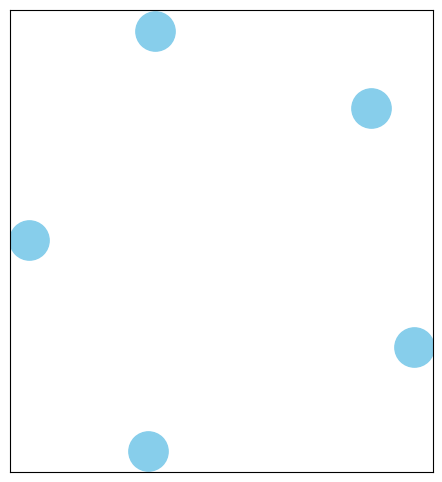

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Funzione per aggiungere rumore ai valori degli attributi dei nodi
def add_noise_to_node_attributes(graph, noise_level=0.1):
    noisy_graph = nx.Graph()

    # Aggiungi i nodi al grafo
    for i in range(graph.num_nodes):
        noisy_graph.add_node(i)

    # Aggiungi gli archi al grafo
    for j in range(graph.num_edges):
        src, dst = graph.edge_index[:, j]
        noisy_graph.add_edge(src.item(), dst.item())

    # Aggiungi rumore agli attributi dei nodi
    for node_index in range(graph.num_nodes):
        node_attributes = graph.x[node_index].numpy()
        noisy_attributes = node_attributes + np.random.normal(0, noise_level, size=node_attributes.shape)
        noisy_graph.nodes[node_index]['attributes'] = noisy_attributes

    return noisy_graph

# Applica l'aumentazione agli attributi del primo grafo nel dataset di addestramento
original_graph_data = train_data[0]
noisy_graph = add_noise_to_node_attributes(original_graph_data, noise_level=0.1)

# Visualizza il grafo originale e il grafo con attributi rumorosi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(train_data[0], with_labels=True, node_color='skyblue', node_size=800, font_size=12, font_weight='bold')
plt.title("Grafo Originale")

plt.subplot(1, 2, 2)
nx.draw(noisy_graph, with_labels=True, node_color='salmon', node_size=800, font_size=12, font_weight='bold')
plt.title("Grafo con Attributi Rumorosi")

plt.tight_layout()
plt.show()


In [ ]:
# installazione e all'importazione di DeepChem, una libreria open-source progettata per l'apprendimento automatico in chimica
!pip install deepchem
import deepchem as dc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.4.23 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.
jaxlib 0.4.23+cuda12.cudnn89 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


NON ABBIA IDs quindi non va

In [ ]:
# suddividere i dati in set di addestramento, validation e test utilizzando la tecnica di suddivisione per scaffold.
import deepchem as dc
from ogb.graphproppred import PygGraphPropPredDataset
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train,test = scaffoldsplitter.split(dataset)
train_idx, valid_idx, test_idx = scaffold_split['train'], scaffold_split['valid'], scaffold_split['test']



AttributeError: 'PygGraphPropPredDataset' object has no attribute 'ids'

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool
from torch.nn import Linear
from ogb.graphproppred import PygGraphPropPredDataset
from sklearn.model_selection import KFold

# Define a simple Graph Neural Network
# definisce una rete neurale per grafi (GNN) usando il modulo torch
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)  # Output will be 2 classes


# è la funzione forward definita all'interno della classe GNN
# viene utilizzata per definire il flusso in avanti (forward pass) del modello.
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = global_max_pool(x, batch)  # Global pooling
        x = self.lin(x)
        return x

# Define train and validate functions
# gestisce il processo di addestramento di un modello di apprendimento automatico.
def train(model, optimizer, train_loader):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y.view(-1).long())
        loss.backward()
        optimizer.step()

# utilizzata per valutare le prestazioni di un modello di apprendimento automatico su un insieme di dati di validazione o test.
def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            pred = model(data.x.float(), data.edge_index, data.batch)
            pred = pred.argmax(dim=1)
            correct += int((pred == data.y.view(-1)).sum())
            total += data.y.size(0)
            all_predictions.extend(pred.tolist())
            all_labels.extend(data.y.view(-1).tolist())

    accuracy = correct / total
    return accuracy, all_predictions, all_labels

# Load dataset
# preparazione dei dati e la configurazione del processo di addestramento del modello.
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')
split_idx = dataset.get_idx_split()
train_idx, val_idx, test_idx=split_idx['train'], split_idx['valid'], split_idx['test']
train_data = dataset[train_idx]
val_data = dataset[val_idx]
test_data = dataset[test_idx]

test_loader = DataLoader(balanced_test_data, batch_size=32, shuffle=False)

# Training loop with cross-validation

train_loader = DataLoader(balanced_train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(balanced_val_data, batch_size=32, shuffle=False)

    # Define the model and optimizer
model = GNN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Early stopping variables
best_val_acc = 0.0
patience = 25  # Stop after no improvement for 25 epochs
counter = 0

# Training loop with validation and early stopping
#  rappresenta un ciclo di addestramento del modello con validazione incrociata.
for epoch in range(1, 101):  # Train for maximum 100 epochs
#Train the model
  train(model, optimizer, train_loader)
        # Validate the model
  val_acc, _, _ = validate(model, val_loader)

  print(f'Fold [{fold+1}/{k_folds}] Epoch: {epoch}, Val Acc: {val_acc:.4f}')

        # Check for improvement in validation accuracy
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    counter = 0  # Reset counter
  else:
    counter += 1  # No improvement, increase counter

        # If no improvement for "patience" number of epochs, stop training
  if counter >= patience:
    print(f'Fold [{fold+1}/{k_folds}] Early stopping at epoch {epoch}')
    break

# Final evaluation on the test set
# calcola e stampa l'accuratezza finale del modello utilizzando i dati di test.
test_acc, all_test_predictions, all_test_labels = validate(model, test_loader)
print(f'Final Test Accuracy: {test_acc:.4f}')

# Print some predictions and labels
print("Sample predictions and labels:")
for i in range(10):  # Print first 10 samples
    print(f"Prediction: {all_test_predictions[i]}, Label: {all_test_labels[i]}")


NameError: name 'balanced_test_data' is not defined

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool
from torch.nn import Linear
from ogb.graphproppred import PygGraphPropPredDataset
from sklearn.model_selection import KFold

# Define Focal Loss
# definisce una classe FocalLoss che implementa la perdita Focal Loss.
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction


# funzione forward definisce il passaggio in avanti (forward pass) della classe FocalLoss.
#Durante la forward pass, viene calcolata la perdita Focal Loss tra gli input e i target.
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Define a simple Graph Neural Network
# definisce una classe GNNche implementa un modello di rete neurale per l'elaborazione dei grafi utilizzando
# layer di convoluzione grafica (GCNConv) e un layer lineare finale (Linear).
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        #self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)  # Output will be 1 for binary classification


# definisce il flusso dei dati attraverso il modello durante la fase di passaggio in avanti (forward pass).
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        #x = self.conv5(x, edge_index)
        #x = x.relu()
        x = global_max_pool(x, batch)  # Global pooling
        x = self.lin(x).squeeze(1)  # Squeeze to remove extra dimension
        return torch.sigmoid(x)  # Sigmoid for binary classification


# implementa il ciclo di addestramento del modello durante l'addestramento.
def train(model, optimizer, train_loader, loss_fn):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.batch)
        target = data.y.view(-1, 1).float()  # Reshape to (batch_size, 1)
        loss = loss_fn(out, target.squeeze(1))
        loss.backward()
        optimizer.step()


# funzione di validazione che valuta le prestazioni del modello su un insieme di dati di validazione o test.
def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            pred = model(data.x.float(), data.edge_index, data.batch)
            pred = (pred > 0.5).float()  # Convert to binary predictions
            correct += int((pred == data.y.view(-1)).sum())
            total += data.y.size(0)
            all_predictions.extend(pred.tolist())
            all_labels.extend(data.y.view(-1).tolist())

    accuracy = correct / total
    return accuracy, all_predictions, all_labels

# Load dataset
# carica un dataset per la classificazione di proprietà di grafi utilizzando PyTorch Geometric (PyG).
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')
split_idx = dataset.get_idx_split()
train_idx, val_idx, test_idx = split_idx['train'], split_idx['valid'], split_idx['test']
train_data = dataset[train_idx]
val_data = dataset[val_idx]
test_data = dataset[test_idx]

# Define cross-validation settings
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Training loop with cross-validation
# implementa un loop di addestramento con validazione incrociata utilizzando la tecnica di focal loss.
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold [{fold + 1}/{k_folds}]")

    # Subset the data for this fold
    train_data = dataset[train_idx]
    val_data = dataset[val_idx]

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

    # Define the model and optimizer
    model = GNN(hidden_channels=64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Create Focal Loss with alpha=1, gamma=2
    focal_loss = FocalLoss(alpha=1, gamma=2)

    # Early stopping variables
    best_val_acc = 0.0
    patience = 25  # Stop after no improvement for 25 epochs
    counter = 0

    # Training loop with validation and early stopping
    for epoch in range(1, 101):  # Train for maximum 100 epochs
        # Train the model
        train(model, optimizer, train_loader, focal_loss)

        # Validate the model
        val_acc, _, _ = validate(model, val_loader)

        print(f'Fold [{fold + 1}/{k_folds}] Epoch: {epoch}, Val Acc: {val_acc:.4f}')

        # Check for improvement in validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0  # Reset counter
        else:
            counter += 1  # No improvement, increase counter

        # If no improvement for "patience" number of epochs, stop training
        if counter >= patience:
            print(f'Fold [{fold + 1}/{k_folds}] Early stopping at epoch {epoch}')
            break

# Final evaluation on the test set
test_acc, all_test_predictions, all_test_labels = validate(model, test_loader)
print(f'Final Test Accuracy: {test_acc:.4f}')

# Print some predictions and labels
print("Sample predictions and labels:")
for i in range(10):  # Print first 10 samples
    print(f"Prediction: {all_test_predictions[i]}, Label: {all_test_labels[i]}")


Fold [1/5]
Fold [1/5] Epoch: 1, Val Acc: 0.9639
Fold [1/5] Epoch: 2, Val Acc: 0.9639
Fold [1/5] Epoch: 3, Val Acc: 0.9639
Fold [1/5] Epoch: 4, Val Acc: 0.9639
Fold [1/5] Epoch: 5, Val Acc: 0.9639
Fold [1/5] Epoch: 6, Val Acc: 0.9639
Fold [1/5] Epoch: 7, Val Acc: 0.9639
Fold [1/5] Epoch: 8, Val Acc: 0.9639
Fold [1/5] Epoch: 9, Val Acc: 0.9639
Fold [1/5] Epoch: 10, Val Acc: 0.9639
Fold [1/5] Epoch: 11, Val Acc: 0.9639
Fold [1/5] Epoch: 12, Val Acc: 0.9639
Fold [1/5] Epoch: 13, Val Acc: 0.9639
Fold [1/5] Epoch: 14, Val Acc: 0.9639
Fold [1/5] Epoch: 15, Val Acc: 0.9639
Fold [1/5] Epoch: 16, Val Acc: 0.9639
Fold [1/5] Epoch: 17, Val Acc: 0.9639
Fold [1/5] Epoch: 18, Val Acc: 0.9639
Fold [1/5] Epoch: 19, Val Acc: 0.9639
Fold [1/5] Epoch: 20, Val Acc: 0.9639
Fold [1/5] Epoch: 21, Val Acc: 0.9639
Fold [1/5] Epoch: 22, Val Acc: 0.9639
Fold [1/5] Epoch: 23, Val Acc: 0.9639
Fold [1/5] Epoch: 24, Val Acc: 0.9639
Fold [1/5] Epoch: 25, Val Acc: 0.9639
Fold [1/5] Epoch: 26, Val Acc: 0.9639
Fold [1/5]

In [ ]:
# calcola la mappa di salienza dei nodi per un dato grafo.
def node_compute_saliency_map(model, data):
    model.eval()
    data.x = data.x.float()  # Cast to float
    data.x.requires_grad = True
    logits = model(data.x, data.edge_index, data.batch)  # Pass data.batch as well
    loss = logits[data.y.squeeze()]  # Assuming binary classification
    loss.backward()

    saliency_map = data.x.grad.abs().sum(dim=-1)  # Sum gradients across feature dimensions
    return saliency_map


# Example usage
# prende il primo elemento dal set di dati di test, quindi chiama la funzione node_compute_saliency_map
# per calcolare la mappa di salienza dei nodi per questo grafo.
data = test_data[0]
print(data.x)

nodes_saliency_map = node_compute_saliency_map(model, data)
print('saliency', nodes_saliency_map)

# Normalize the saliency map
#node_normalized_saliency_map = torch.abs(nodes_saliency_map) / torch.abs(nodes_saliency_map).max()

# Get the indices of the features in descending order of importance
#node_sorted_indices = torch.argsort(node_normalized_saliency_map, descending=True)

# Print the normalized saliency map and sorted indices
print("Normalized Saliency Map:")
print(node_normalized_saliency_map)

print("\nSorted Indices (from most important to least important):")
print(node_sorted_indices)

tensor([[ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [28,  0,  4,  2,  0,  0,  5,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  1],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  1],
        [ 5,  0,  3,  5,  0,  0,  1,  0,  1],
        [ 5,  0,  4,  5,  2,  0,  2,  0,  0],
        [ 5,  0,  4,  5,  3,  0,  2,  0,  0],
        [ 7,  0,  2,  6,  0,  0,  1,  0,  1]])
saliency tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Normalized Saliency Map:
tensor

In [ ]:
# calcola la mappa di salienza delle caratteristiche dei nodi per un grafo utilizzando il modello specificato.
def feat_saliency_map_transposed(model, data):
    model.eval()
    x = data.x.float()  # Cast to float
    x.requires_grad = True
    # Forward pass through the model
    logits = model(x, data.edge_index, data.batch)
    loss = logits[data.y.squeeze()]
    loss.backward()
    # Manually compute the gradient with respect to the input tensor
    gradient = x.grad.clone()  # Use x instead of data.x

    # Transpose the node features tensor
    x_transposed = x.transpose(0, 1)

    # Transpose the gradient tensor
    gradient_transposed = gradient.transpose(0, 1)

    # Calculate the saliency map
    saliency_map_transposed = gradient_transposed.abs().sum(dim=-1)  # Sum gradients across feature dimensions

    return saliency_map_transposed

# Calcola la mappa di salienza delle caratteristiche dei nodi utilizzando la funzione feat_saliency_map_transposed precedentemente definita.
feat_saliency_map = feat_saliency_map_transposed(model,data)
# Normalizza la mappa di salienza assolutizzando i valori e dividendo per il massimo valore assoluto
feat_normalized_saliency_map = torch.abs(feat_saliency_map) / torch.abs(feat_saliency_map).max()

# vengono ottenuti gli indici delle caratteristiche ordinati in ordine decrescente di importanza utilizzando torch.argsort
feat_sorted_indices = torch.argsort(feat_normalized_saliency_map, descending=True)

# Print the normalized saliency map and sorted indices
print("Normalized Saliency Map:")
print(feat_normalized_saliency_map)

print("\nSorted Indices (from most important to least important):")
print(feat_sorted_indices)

Normalized Saliency Map:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])

Sorted Indices (from most important to least important):
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)
Normalized Saliency Map:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Sorted Indices (from most important to least important):
tensor([ 9, 18, 17, 16, 15, 14, 13, 12, 11, 10,  0,  8,  7,  6,  5,  4,  3,  2,
         1])
Normalized Saliency Map:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan])

Sorted Indices (from most important to least important):
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


StopIteration: 

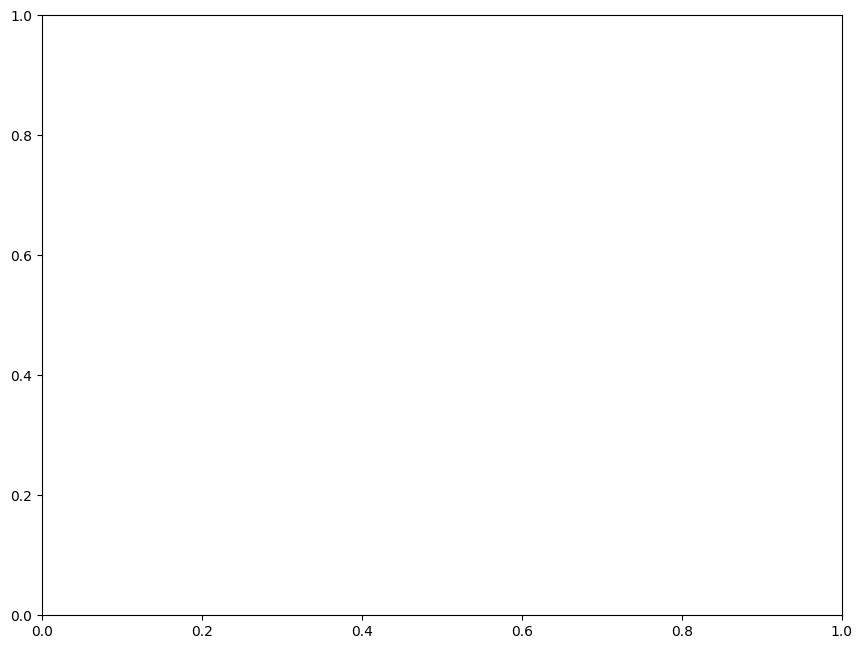

In [ ]:
import networkx as nx
for data in test_data: #itera attraverso ogni campione nel test_data
  print(data)
  nodes_saliency_map = node_compute_saliency_map(model, data) # r ogni campione, calcola la mappa di salienza dei nodi utilizzando la funzione node_compute_saliency_map(model, data).

  # Normalizza la mappa di salienza dei nodi assolutizzando i valori e dividendo per il massimo valore assoluto.
  node_normalized_saliency_map = torch.abs(nodes_saliency_map) / torch.abs(nodes_saliency_map).max()

  # Ottiene gli indici dei nodi ordinati in ordine decrescente di importanza utilizzando torch.argsort.
  node_sorted_indices = torch.argsort(node_normalized_saliency_map, descending=True)

  # Print the normalized saliency map and sorted indices
  print("Normalized Saliency Map:")
  print(node_normalized_saliency_map)

  print("\nSorted Indices (from most important to least important):")
  print(node_sorted_indices)

  feat_saliency_map = feat_saliency_map_transposed(model,data) # calcola e normalizza la mappa di salienza delle caratteristiche trasposta utilizzando feat_saliency_map_transposed(model,data)
  # Normalize the saliency map
  feat_normalized_saliency_map = torch.abs(feat_saliency_map) / torch.abs(feat_saliency_map).max()

  # Ottiene gli indici delle caratteristiche ordinati in ordine decrescente di importanza utilizzando torch.argsort.
  feat_sorted_indices = torch.argsort(feat_normalized_saliency_map, descending=True)

  # Stampa la mappa di salienza normalizzata e gli indici ordinati per le caratteristiche.
  print("Normalized Saliency Map:")
  print(feat_normalized_saliency_map)

# plotta il grafo e l'istogramma delle caratteristiche utilizzando le funzioni plot_graph() e plot_hist_feat() (che non sono definite nel codice fornito).
  print("\nSorted Indices (from most important to least important):")
  print(feat_sorted_indices)
  plot_graph(data, node_normalized_saliency_map)
  print('\n')
  plot_hist_feat(feat_normalized_saliency_map)
  print('\n')


#MAIN

In [ ]:
# Define a simple Graph Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear, BatchNorm1d

# definisce una rete neurale GNN
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(9, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)  # Output will be 2 classes

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = global_max_pool(x, batch)  # Global pooling
        x = self.lin(x)
        return x

# è responsabile di addestrare il modello della rete neurale.
def train(model, optimizer, train_loader):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y.view(-1).long())
        loss.backward()
        optimizer.step()

# è utilizzata per valutare le prestazioni del modello su un insieme di dati di validazione o test
def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            pred = model(data.x.float(), data.edge_index, data.batch)
            pred = pred.argmax(dim=1)
            correct += int((pred == data.y.view(-1)).sum())
            total += data.y.size(0)
            all_predictions.extend(pred.tolist())
            all_labels.extend(data.y.view(-1).tolist())

    accuracy = correct / total
    return accuracy, all_predictions, all_labels


In [ ]:
# calcola la mappa di salienza dei nodi rispetto alla classificazione del modello
def node_compute_saliency_map(model, data):
    model.eval()
    data.x = data.x.float()  # Cast to float
    data.x.requires_grad = True
    logits = model(data.x, data.edge_index, data.batch)  # Pass data.batch as well
    loss = logits[0, data.y.squeeze()]  # Assuming binary classification
    loss.backward()

    saliency_map = data.x.grad.abs().sum(dim=-1)  # Sum gradients across feature dimensions
    return saliency_map

# calcola la mappa di salienza delle feature dei nodi trasposta rispetto alla classificazione del modello
def feat_saliency_map_transposed(model, data):
    model.eval()
    x = data.x.float()  # Cast to float
    x.requires_grad = True
    # Forward pass through the model
    logits = model(x, data.edge_index, data.batch)
    loss = logits[0, data.y.squeeze()]
    loss.backward()
    # Manually compute the gradient with respect to the input tensor
    gradient = x.grad.clone()  # Use x instead of data.x

    # Transpose the node features tensor
    x_transposed = x.transpose(0, 1)

    # Transpose the gradient tensor
    gradient_transposed = gradient.transpose(0, 1)

    # Calculate the saliency map
    saliency_map_transposed = gradient_transposed.abs().sum(dim=-1)  # Sum gradients across feature dimensions

    return saliency_map_transposed

In [ ]:
# è progettata per visualizzare un grafo utilizzando la libreria NetworkX, con la colorazione dei nodi basata sulla mappa di salienza dei nodi
from rdkit import Chem
import matplotlib.pyplot as plt
def plot_graph(data, nodes_saliency_map):
  tp = Chem.GetPeriodicTable()
  G = nx.Graph()
  elements = {}
  for i in range(data["num_nodes"]):
      first_element_int = int(data.x[i][0].item())
      elements[i] = tp.GetElementSymbol(first_element_int)
      G.add_node(i)  # Redder for higher saliency

  # Add edges
  for i in range(data["edge_index"].shape[1]):
      source = data["edge_index"][0, i].item()
      target = data["edge_index"][1, i].item()
      G.add_edge(source, target)

  # Get node colors for plotting
  # Get node colors and sizes for plotting
  node_colors = [nodes_saliency_map[i].item() for i in range(nodes_saliency_map.shape[0])]
  node_sizes = [nodes_saliency_map[i].item() * 3000 for i in range(nodes_saliency_map.shape[0])]

  # Plot the graph
  plt.figure(figsize=(8, 6))
  pos = nx.spring_layout(G, seed=42)  # Position nodes using a spring layout
  nx.draw(G, pos, with_labels=True, labels = elements, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Reds, font_size=10, font_color="black")
  plt.title("Graph with Node Salience")
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Reds), label="Node Salience")
  plt.show()

In [ ]:
#  è progettata per visualizzare un istogramma che rappresenta l'importanza normalizzata delle caratteristiche (feature) del grafo
def plot_hist_feat(feat_normalized_saliency_map):
  # Create histogram
  plt.figure(figsize=(10, 6))
  plt.bar(range(len(feat_normalized_saliency_map.detach().numpy())), feat_normalized_saliency_map.detach().numpy(), color='skyblue')
  plt.xlabel('Feature Index')
  plt.ylabel('Normalized Importance')
  plt.title('Normalized Feature Importance')
  plt.xticks(range(len(feat_normalized_saliency_map)))  # Use feature index as x-ticks
  plt.tight_layout()
  plt.show()

In [ ]:
from rdkit import Chem
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool
from torch.nn import Linear
from ogb.graphproppred import PygGraphPropPredDataset
from sklearn.model_selection import KFold
import numpy as np

# addestra e valida un modello utilizzando la tecnica della cross-validation
def train_test_model():
  tp = Chem.GetPeriodicTable()
  # Load dataset
  dataset = PygGraphPropPredDataset(name='ogbg-molhiv')
  split_idx = dataset.get_idx_split()
  train_idx, val_idx, test_idx=split_idx['train'], split_idx['valid'], split_idx['test']
  train_data = dataset[train_idx]
  val_data = dataset[val_idx]
  test_data = dataset[test_idx]

  # Define cross-validation settings
  k_folds = 5
  kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
  label_0_indices_te = (test_data.y == 0).nonzero(as_tuple=True)[0].reshape(-1)
  label_1_indices_te = (test_data.y == 1).nonzero(as_tuple=True)[0].reshape(-1)

  min_size_test = min(label_0_indices_te.size(0), label_1_indices_te.size(0))

  label_0_indices_te = label_0_indices_te[:min_size_test]
  label_1_indices_te = label_1_indices_te[:min_size_test]

  balanced_indices_te = torch.cat([label_0_indices_te, label_1_indices_te])

  balanced_test_data = test_data[balanced_indices_te]

  test_loader = DataLoader(balanced_test_data, batch_size=32, shuffle=False)

  # Training loop with cross-validation
  for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
      print(f"Fold [{fold+1}/{k_folds}]")

      # Subset the data for this fold
      train_data = dataset[train_idx]
      val_data = dataset[val_idx]

      # Separate data by class labels
      label_0_indices_tr = (train_data.y == 0).nonzero(as_tuple=True)[0].reshape(-1)
      label_1_indices_tr = (train_data.y == 1).nonzero(as_tuple=True)[0].reshape(-1)

      label_0_indices_vl = (val_data.y == 0).nonzero(as_tuple=True)[0].reshape(-1)
      label_1_indices_vl = (val_data.y == 1).nonzero(as_tuple=True)[0].reshape(-1)

      # Determine the size of the smaller class
      min_size_train = min(label_0_indices_tr.size(0), label_1_indices_tr.size(0))
      min_size_val = min(label_0_indices_vl.size(0), label_1_indices_vl.size(0))

      # Sample equal number of elements from each class
      label_0_indices_tr = label_0_indices_tr[:min_size_train]
      label_1_indices_tr = label_1_indices_tr[:min_size_train]

      label_0_indices_vl = label_0_indices_vl[:min_size_val]
      label_1_indices_vl = label_1_indices_vl[:min_size_val]

      # Concatenate the indices
      balanced_indices_tr = torch.cat([label_0_indices_tr, label_1_indices_tr])
      balanced_indices_vl = torch.cat([label_0_indices_vl, label_1_indices_vl])

      # Create a new dataset with balanced samples
      balanced_train_data = train_data[balanced_indices_tr]
      balanced_val_data = val_data[balanced_indices_vl]

      train_loader = DataLoader(balanced_train_data, batch_size=32, shuffle=True)
      val_loader = DataLoader(balanced_val_data, batch_size=32, shuffle=False)

      # Define the model and optimizer
      model = GNN(hidden_channels=64)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

      # Early stopping variables
      best_val_acc = 0.0
      patience = 25  # Stop after no improvement for 25 epochs
      counter = 0

      # Training loop with validation and early stopping
      for epoch in range(1, 101):  # Train for maximum 100 epochs
          #Train the model
          train(model, optimizer, train_loader)

          # Validate the model
          val_acc, _, _ = validate(model, val_loader)

          print(f'Fold [{fold+1}/{k_folds}] Epoch: {epoch}, Val Acc: {val_acc:.4f}')

          # Check for improvement in validation accuracy
          if val_acc > best_val_acc:
              best_val_acc = val_acc
              counter = 0  # Reset counter
          else:
              counter += 1  # No improvement, increase counter

          # If no improvement for "patience" number of epochs, stop training
          if counter >= patience:
              print(f'Fold [{fold+1}/{k_folds}] Early stopping at epoch {epoch}')
              break

  # esegue la validazione finale del modello sul set di test bilanciato e calcola alcune metriche
  # di valutazione della classificazione binaria, come l'accuratezza, la precisione, il richiamo (o recall) e il punteggio F1.
  test_acc, all_test_predictions, all_test_labels = validate(model, test_loader)
  print(f'Final Test Accuracy: {test_acc:.4f}')


  # Convert predictions and labels to numpy arrays
  all_test_predictions = np.array(all_test_predictions)
  all_test_labels = np.array(all_test_labels)

  # Calculate True Positives (TP), False Positives (FP),
  # True Negatives (TN), False Negatives (FN)
  TP = np.sum((all_test_predictions == 1) & (all_test_labels == 1))
  FP = np.sum((all_test_predictions == 1) & (all_test_labels == 0))
  TN = np.sum((all_test_predictions == 0) & (all_test_labels == 0))
  FN = np.sum((all_test_predictions == 0) & (all_test_labels == 1))

  print("True Positives (TP):", TP)
  print("False Positives (FP):", FP)
  print("True Negatives (TN):", TN)
  print("False Negatives (FN):", FN)

  # Calculate accuracy, precision, recall, and F1-score
  accuracy = (TP + TN) / (TP + FP + TN + FN)
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1_score = 2 * (precision * recall) / (precision + recall)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1_score)

  return model, balanced_test_data

model, balanced_test_data = train_test_model()


Downloaded 0.00 GB: 100%|██████████| 3/3 [00:00<00:00,  5.59it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 62408.41it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:04<00:00, 10262.38it/s]


Saving...


Done!


Fold [1/5]
Fold [1/5] Epoch: 1, Val Acc: 0.5000
Fold [1/5] Epoch: 2, Val Acc: 0.5000
Fold [1/5] Epoch: 3, Val Acc: 0.5000
Fold [1/5] Epoch: 4, Val Acc: 0.5000
Fold [1/5] Epoch: 5, Val Acc: 0.5000
Fold [1/5] Epoch: 6, Val Acc: 0.5000
Fold [1/5] Epoch: 7, Val Acc: 0.5000
Fold [1/5] Epoch: 8, Val Acc: 0.5000
Fold [1/5] Epoch: 9, Val Acc: 0.5000
Fold [1/5] Epoch: 10, Val Acc: 0.5000
Fold [1/5] Epoch: 11, Val Acc: 0.5438
Fold [1/5] Epoch: 12, Val Acc: 0.5690
Fold [1/5] Epoch: 13, Val Acc: 0.5640
Fold [1/5] Epoch: 14, Val Acc: 0.5640
Fold [1/5] Epoch: 15, Val Acc: 0.5640
Fold [1/5] Epoch: 16, Val Acc: 0.5640
Fold [1/5] Epoch: 17, Val Acc: 0.5825
Fold [1/5] Epoch: 18, Val Acc: 0.5640
Fold [1/5] Epoch: 19, Val Acc: 0.5640
Fold [1/5] Epoch: 20, Val Acc: 0.5640
Fold [1/5] Epoch: 21, Val Acc: 0.5640
Fold [1/5] Epoch: 22, Val Acc: 0.5640
Fold [1/5] Epoch: 23, Val Acc: 0.5640
Fold [1/5] Epoch: 24, Val Acc: 0.5640
Fold [1/5] Epoch: 25, Val Acc: 0.5640
Fold [1/5] Epoch: 26, Val Acc: 0.5640
Fold [1/5]

In [ ]:
# identifica gli indici delle istanze nel set di test test_data con etichetta 0 e 1 utilizzando la funzione nonzero. Questi indici
#vengono memorizzati in label_0_indices_te e label_1_indices_te, rispettivamente.
label_0_indices_te = (test_data.y == 0).nonzero(as_tuple=True)[0].reshape(-1)
label_1_indices_te = (test_data.y == 1).nonzero(as_tuple=True)[0].reshape(-1)

# Stampa gli indici delle istanze con etichetta 0 e 1.
print(label_0_indices_te)
print(label_1_indices_te)

# Calcola la dimensione minima tra gli indici delle istanze con etichetta 0 e 1 utilizzando la funzione min.
min_size_test = min(label_0_indices_te.size(0), label_1_indices_te.size(0))

print(min_size_test)

# limita gli indici delle istanze con etichetta 0 e 1 alla dimensione minima calcolata nella fase precedente utilizzando l'indicizzazione degli array.
label_0_indices_te = label_0_indices_te[:min_size_test]
label_1_indices_te = label_1_indices_te[:min_size_test]

# stampa gli indici delle istanze con etichetta 0 e 1 dopo il ridimensionamento.
print(label_0_indices_te)
print(label_1_indices_te)

# concatena gli indici delle istanze con etichetta 0 e 1 bilanciate utilizzando la funzione torch.cat e crea un nuovo
#  set di dati di test bilanciato balanced_test_data.
balanced_indices_te = torch.cat([label_0_indices_te, label_1_indices_te])

# Stampa il nuovo set di dati di test bilanciato.
balanced_test_data = test_data[balanced_indices_te]
print(balanced_test_data)

tensor([   0,    1,    2,  ..., 4110, 4111, 4112])
tensor([  59,   62,   90,   98,  121,  140,  187,  196,  366,  395,  428,  440,
         443,  444,  445,  446,  459,  460,  462,  463,  464,  467,  468,  469,
         470,  597,  638,  685,  695,  697,  698,  699,  707,  730,  739,  740,
         741,  742,  769,  772,  801,  826,  855,  858,  906,  946,  947,  948,
         949,  950,  951,  956,  969,  975,  977, 1050, 1102, 1110, 1191, 1192,
        1370, 1419, 1432, 1473, 1475, 1611, 1653, 1665, 1753, 1784, 1823, 1831,
        2063, 2085, 2135, 2252, 2256, 2326, 2358, 2445, 2456, 2522, 2523, 2592,
        2635, 2696, 2705, 2769, 2795, 2797, 2847, 2962, 3014, 3057, 3063, 3072,
        3077, 3082, 3146, 3252, 3266, 3287, 3355, 3404, 3411, 3412, 3446, 3479,
        3543, 3553, 3554, 3566, 3590, 3643, 3665, 3684, 3772, 3774, 3800, 3814,
        3837, 3855, 3859, 3860, 3862, 3865, 4001, 4060, 4083, 4084])
130
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13

In [ ]:
# identifica gli indici delle istanze con etichetta 0 e 1 nel set di test test_data utilizzando la funzione nonzero. Questa volta,
# il parametro as_tuple è impostato su False, il che restituisce un tensore piatto invece di una tupla di tensori.
label_0_indices_te = (test_data.y == 0).nonzero(as_tuple=False).reshape(-1)
label_1_indices_te = (test_data.y == 1).nonzero(as_tuple=False).reshape(-1)

# Stampa gli indici delle istanze con etichetta 0 e 1.
print(label_0_indices_te)
print(label_1_indices_te)

# Calcola la dimensione minima tra gli indici delle istanze con etichetta 0 e 1 utilizzando la funzione min.
min_size_test = min(label_0_indices_te.size(0), label_1_indices_te.size(0))

print(min_size_test)

# Limita gli indici delle istanze con etichetta 0 e 1 alla dimensione minima calcolata nella fase precedente utilizzando l'indicizzazione degli array.
label_0_indices_te = label_0_indices_te[:min_size_test]
label_1_indices_te = label_1_indices_te[:min_size_test]

# Stampa gli indici delle istanze con etichetta 0 e 1 dopo il ridimensionamento.
print(label_0_indices_te)
print(label_1_indices_te)

# Concatena gli indici delle istanze con etichetta 0 e 1 bilanciate utilizzando la funzione torch.cat e
balanced_indices_te = torch.cat([label_0_indices_te, label_1_indices_te])

balanced_test_data = test_data[balanced_indices_te] # #  crea un nuovo set di dati di test bilanciato balanced_test_data.
print(balanced_test_data) # stampa il nuovo set di dati di test bilanciato

tensor([   0,    0,    1,  ...,    0, 4112,    0])
tensor([  59,    0,   62,    0,   90,    0,   98,    0,  121,    0,  140,    0,
         187,    0,  196,    0,  366,    0,  395,    0,  428,    0,  440,    0,
         443,    0,  444,    0,  445,    0,  446,    0,  459,    0,  460,    0,
         462,    0,  463,    0,  464,    0,  467,    0,  468,    0,  469,    0,
         470,    0,  597,    0,  638,    0,  685,    0,  695,    0,  697,    0,
         698,    0,  699,    0,  707,    0,  730,    0,  739,    0,  740,    0,
         741,    0,  742,    0,  769,    0,  772,    0,  801,    0,  826,    0,
         855,    0,  858,    0,  906,    0,  946,    0,  947,    0,  948,    0,
         949,    0,  950,    0,  951,    0,  956,    0,  969,    0,  975,    0,
         977,    0, 1050,    0, 1102,    0, 1110,    0, 1191,    0, 1192,    0,
        1370,    0, 1419,    0, 1432,    0, 1473,    0, 1475,    0, 1611,    0,
        1653,    0, 1665,    0, 1753,    0, 1784,    0, 1823,    0, 1

In [ ]:
import networkx as nx

#  cicla attraverso il set di dati di test bilanciato balanced_test_data e calcola le mappe di salienza per i nodi e le feature per ciascuna istanza di dati.
for data in balanced_test_data:
  nodes_saliency_map = node_compute_saliency_map(model, data)

  # Normalizza la mappa di salienza
  node_normalized_saliency_map = torch.abs(nodes_saliency_map) / torch.abs(nodes_saliency_map).max()

  # Ottieni gli indici delle caratteristiche in ordine decrescente di importanza
  node_sorted_indices = torch.argsort(node_normalized_saliency_map, descending=True)

  # Stampa la mappa di salienza normalizzata e gli indici ordinati
  print("Normalized Saliency Map:")
  print(node_normalized_saliency_map)

  print("\nSorted Indices (from most important to least important):")
  print(node_sorted_indices)

  feat_saliency_map = feat_saliency_map_transposed(model,data)
  # Normalizza la saliency map
  feat_normalized_saliency_map = torch.abs(feat_saliency_map) / torch.abs(feat_saliency_map).max()

  # Ottieni gli indici delle caratteristiche in ordine decrescente di importanza
  feat_sorted_indices = torch.argsort(feat_normalized_saliency_map, descending=True)

  # Stampa la mappa di salienza normalizzata e gli indici ordinati
  print("Normalized Saliency Map:")
  print(feat_normalized_saliency_map)

  print("\nSorted Indices (from most important to least important):")
  print(feat_sorted_indices)
  plot_graph(data, node_normalized_saliency_map)
  print('\n')
  plot_hist_feat(feat_normalized_saliency_map)
  print('\n')
